<a href="https://colab.research.google.com/github/lookingglasslab/VisualFeatureSearch/blob/widen-support/notebooks/Interactive_Visual_Feature_Search_Basic_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Visual Feature Search
## Basic Demo

This colab notebook implements our interactive visual feature search, which allows a user to highlight a free-form region in an image and do a "reverse image search" in CNN intermediate features for similar regions in a dataset.

In this notebook, we use cached ResNet-50 activations for Imagenet's 50k validation set.

For fastest results, enable colab's GPU runtime. With a GPU, the search should take 30-60 seconds. For source code, see our [Github repo](https://github.com/lookingglasslab/VisualFeatureSearch).

We recommend you execute cell blocks sequentially one at a time. In particular, make sure to *download the ImageNet validation images* (see the next cell for instructions).

##  Download ImageNet validation images (**Action Required**)
We use a subset of the ImageNet validation set as our searchable database for visual feature search. To get the dataset:
1. Go to image-net.org and login or signup for access.
2. Go to the following URL: https://image-net.org/challenges/LSVRC/2012/2012-downloads.php
3. Copy the URL for downloading all validation images (with file size of 6.3Gb), and paste the URL below.
4. Run the script below to download the validation set and the ImageNet devkit in Colab.

In [ ]:
!wget https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar # TODO: replace me
!wget https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz

## Other downloads and Python initialization

In [ ]:
# MS Azure downloading util
!wget https://azcopyvnext.azureedge.net/release20220511/azcopy_linux_amd64_10.15.0.tar.gz
!tar -xvf azcopy_linux_amd64_10.15.0.tar.gz

!pip install zarr

# RN50 features
!./azcopy_linux_amd64_10.15.0/azcopy copy https://vissearch.blob.core.windows.net/data/ResNet_ImageNet_val.tar.gz ResNet_ImageNet_val.tar.gz
!tar -xzf ResNet_ImageNet_val.tar.gz

In [ ]:
!pip install -i https://test.pypi.org/simple/ --no-deps visualfeaturesearch==0.0.10

In [3]:
import sys
import numpy as np
import requests
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

import torch
import torchvision
from torchvision import transforms
import zarr

import visualfeaturesearch as vfs
from visualfeaturesearch.searchtool import CachedSearchTool

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  raise Exception('No GPU available')

## Searching for similar image patches via ResNet50 Features

First, select the image you'd like to visualize and then hold down your mouse click and highlight the region you'd like to search for similarly encoded regions.

In [ ]:
# set up the ResNet50 model and search tool
sv_inet_model = torchvision.models.resnet50(pretrained=True)
sv_inet_model = sv_inet_model.cuda().eval()

sv_inet_conv5 = vfs.util.FeatureHook(sv_inet_model, sv_inet_model.layer4[2].conv2)

# set up dataset
vis_imagenet_dataset = torchvision.datasets.ImageNet('./', 'val', transform=vfs.data.vis_transform)

# set up cached search tool
sv_inet_store = zarr.DirectoryStore('ResNet_ImageNet_val')
sv_inet_root = zarr.group(store=sv_inet_store, overwrite=False)
sv_inet_conv5_data = sv_inet_root['conv5']

cached_search_tool = CachedSearchTool(sv_inet_conv5, sv_inet_conv5_data, device, batch_size=5000)

Note: we use Zarr to store & load our precomputed feature data. The variable `sv_inet_conv5_data` above acts like a NumPy array of shape (50000, 512, 7, 7) but its contents are lazily loaded from disk rather than entirely stored in RAM.

In [5]:
# download ten query images to use (sourced from the ImageNet test set)
query_img_ids = ["004", "530", "495", "211", "652", "021", "686", "016", "713", "198"]

def load_img(idx: str):
  url = "https://vissearch.blob.core.windows.net/query-imgs/ILSVRC2012_test_00000" + idx + ".JPEG"
  img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
  return img

query_imgs = [load_img(id) for id in query_img_ids]
vis_query_imgs = [vfs.data.vis_transform(img) for img in query_imgs]
model_query_imgs = [vfs.data.net_transform(img) for img in query_imgs]

# convert images to Data URLs so we can pass them into the HTML widget
query_img_urls = [vfs.util.image_to_durl(img) for img in vis_query_imgs]

highlight_data = None
highlight_index = None
def highlight_callback(data):
    global highlight_data, highlight_index
    highlight_data = data[0]
    highlight_index = data[1]
vfs.util.create_callback('highlight_callback', highlight_callback)

vfs.widgets.MultiHighlightWidget(all_urls=query_img_urls, callback_name='highlight_callback')

Next, we search for the most similar image regions, as encoded by an ImageNet-trained ResNet50 in the 5th convolutional block (see "Experimental Details" in our paper for more on layer selection).

In [6]:
assert highlight_data is not None, "Use the widget to highlight an image region"

selected_idx = int(highlight_index)
mask = vfs.util.durl_to_image(highlight_data)

cached_search_tool.set_input_image(model_query_imgs[selected_idx])

# turn the user's highlighted mask into a 7x7 grayscale array
conv5_transform = transforms.Resize(7)
conv5_mask = conv5_transform(mask)
conv5_mask_arr = np.asarray(conv5_mask)[:,:,3] / 255

print('Loading results...')
conv5_sims, conv5_xs, conv5_ys = cached_search_tool.compute(conv5_mask_arr)
conv5_order = torch.argsort(conv5_sims, descending=True)
print('Done.')

Loading results...
Done.


Now, we show the top 5 most similar image regions and show their cosine similarity score to the highlighted region in the query image.

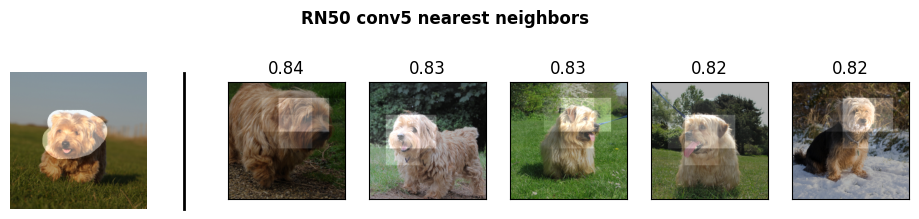

In [7]:
# set up the figure
DISPLAY_NUM = 5

fig = plt.figure(figsize=(11.6, 5.15), dpi=100)
fig.suptitle('RN50 conv5 nearest neighbors', fontweight='bold', y=0.75)
gs = fig.add_gridspec(1,2, width_ratios=[1,5])
results_gs = gs[1].subgridspec(1,DISPLAY_NUM)

# show the query region on the left-hand side
ax = fig.add_subplot(gs[0])
ax.axis('off')
ax.imshow(vfs.util.mask_overlay(vis_query_imgs[selected_idx], 0, 0, 224, np.asarray(mask)[:,:,3] / 256))
ax.add_line(matplotlib.lines.Line2D([285,285], [0,224], lw=2, color='black')).set_clip_on(False)

# include the most similar images from the dataset on the right side
for i in range(DISPLAY_NUM):
  idx = conv5_order[i]
  curr_img_out = vfs.util.mask_overlay(vis_imagenet_dataset[idx][0],
                                   x=conv5_xs[idx],
                                   y=conv5_ys[idx],
                                   mask_size=7,
                                   mask=vfs.util.crop_mask(conv5_mask_arr))

  ax = fig.add_subplot(results_gs[i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray')
  ax.set_title( f'{conv5_sims[idx].cpu().numpy():.02f}')